In [2]:
import os
import shutil
import yaml
import argparse
import note_seq
import torch
import torch.nn as nn
import time
from tensorboardX import SummaryWriter
from optim import Optimizer
from model.encoder import build_encoder
from model.decoder import build_decoder
from model.ListenAttendSpell import ListenAttendSpell
from utils import  AttrDict, init_logger
from dataset import MAESTRO, collate_fn, worker_init_fn
from torch.utils.data import DataLoader
from data import run_length_encoding, event_codec, vocabularies, spectrograms

In [3]:
with open('config/model.yaml', 'r') as f:
    file_config = yaml.safe_load(f)
config = AttrDict(file_config)

In [4]:
codec = event_codec.Codec(
                max_shift_steps=config.data.max_shift_steps,
                steps_per_second=config.data.steps_per_second,
                event_ranges=[
                    event_codec.EventRange('pitch', note_seq.MIN_MIDI_PITCH,
                                note_seq.MAX_MIDI_PITCH),
                    event_codec.EventRange('velocity', 0, 127)
                ])
run_length_encode_shifts = run_length_encoding.run_length_encode_shifts_fn(
        codec=codec)
vocab = vocabularies.vocabulary_from_codec(codec)
spectrogram_config = spectrograms.SpectrogramConfig()

In [5]:
validation_dataset =MAESTRO(
        config = config.data,
        type = 'validation',
        codec = codec,
        run_length_encode_shifts = run_length_encode_shifts,
        spectrogram_config = spectrogram_config,
        vocab = vocab)

Loding 1 group of MAESTRO at /home/ubuntu/seq2seq-music-transcription/data/MAESTRO


Loading groups validation: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


In [6]:
validation_dataloader = DataLoader(
        validation_dataset, 
        batch_size = config.data.batch_size * config.training.num_gpu,
        shuffle=False,
        collate_fn = collate_fn,
        worker_init_fn = worker_init_fn,
        num_workers=2)

In [7]:
vocab._base_vocab_size

560

In [8]:
for i in range(10):
    for step, (audio_batch, label_batch, audio_lengths, labels_lengths) in enumerate(validation_dataloader):
        if step == 0:
            print(labels_lengths[0])
            print(label_batch[0][10:20])
            #print(audio_lengths[10:20])

tensor(28.)
tensor([338, 477, 338,  39, 432, 350, 442, 350, 106, 432])
tensor(14.)
tensor([383, 133, 485, 350,  -1,  -1,  -1,  -1,  -1,  -1])
tensor(105.)
tensor([371,  30, 432, 371,  32, 481, 366,  35, 488, 342])
tensor(81.)
tensor([484, 370, 489, 362,  35, 432, 370,  36, 432, 362])
tensor(11.)
tensor([345,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1])
tensor(100.)
tensor([527, 350,  37, 432, 345, 432, 357, 432, 376, 432])
tensor(101.)
tensor([352,  18, 432, 340,  21, 432, 364,  22, 512, 368])
tensor(169.)
tensor([499, 336,  14, 461, 389,  15, 434, 347,  32, 509])
tensor(76.)
tensor([432, 375,  41, 432, 347,  42, 488, 349, 508, 375])
tensor(42.)
tensor([432, 353, 432, 360, 432, 365, 432, 369,  12, 432])


In [11]:
print(label_batch[0][10:20])
print(vocab._encode(label_batch[0][10:20]))

tensor([432, 353, 432, 360, 432, 365, 432, 369,  12, 432])
[tensor(435), tensor(356), tensor(435), tensor(363), tensor(435), tensor(368), tensor(435), tensor(372), tensor(15), tensor(435)]


In [3]:
encoder = build_encoder(config.model.encoder)
decoder = build_decoder(config.model.decoder)
model = ListenAttendSpell(encoder, decoder)

In [4]:
audio_batch = torch.rand(3,100,512)
audio_lengths = torch.Tensor([100,100,100])
label_batch = torch.randint(1,100, (3,100))
label_lengths = torch.Tensor([100,100,100])

In [8]:
model_states = model.get_model_state(model, 10)

In [10]:
model = ListenAttendSpell.load_model(model_states)

In [36]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
y, sr = librosa.load("/Users/donghyunlee/Desktop/encoder_decoder_model/data_input/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.flac", sr=16000)
y = y[32000:48000]

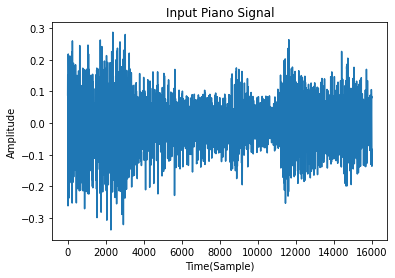

In [40]:
plt.plot(y);
plt.title('Input Piano Signal');
plt.xlabel('Time(Sample)');
plt.ylabel('Amplitude');

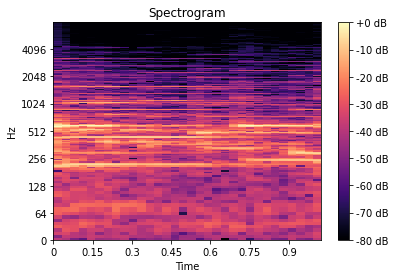

In [46]:
hop_length = 512
n_fft = 2048

spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.title('Spectrogram');
plt.colorbar(format='%+2.0f dB');

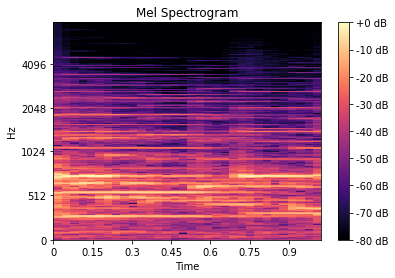

In [47]:
mel_spect = librosa.feature.melspectrogram(y, n_fft=n_fft, hop_length=hop_length, n_mels=512)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, sr=16000, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

In [1]:
import torch

In [2]:
test = torch.load("/home/ubuntu/seq2seq-music-transcription/MAESTRO/maestro/exp/las_model/las_model.epoch2.chkpt")

In [3]:
test

{'encoder': {'input_size': 512,
  'hidden_size': 1024,
  'num_layers': 4,
  'dropout': 0.2},
 'decoder': {'vocab_size': 560,
  'embedding_dim': 512,
  'decoder_hidden_size': 2048,
  'encoder_hidden_size': 1024,
  'num_layers': 1,
  'sos_id': 2,
  'eos_id': 1},
 'encoder_state_dict': OrderedDict([('rnn.weight_ih_l0',
               tensor([[ 0.0268, -0.0119, -0.0137,  ...,  0.0286, -0.0110, -0.0281],
                       [ 0.0304, -0.0245,  0.0150,  ..., -0.0187, -0.0127,  0.0092],
                       [ 0.0090, -0.0198,  0.0268,  ..., -0.0174, -0.0296, -0.0158],
                       ...,
                       [-0.0133, -0.0031,  0.0153,  ..., -0.0279,  0.0027, -0.0038],
                       [ 0.0119,  0.0213, -0.0112,  ..., -0.0296, -0.0237, -0.0051],
                       [ 0.0106, -0.0298,  0.0118,  ...,  0.0078, -0.0101, -0.0058]],
                      device='cuda:0')),
              ('rnn.weight_hh_l0',
               tensor([[ 0.0259,  0.0206, -0.0188,  ...,  0.0008, -